# Exercise 1 - energy data forecasting ⚡

Forecasting energy demand is big business and very important in helping energy producers maintain the balance within the electrical grid. You can find forecasts of energy demands for France in realtime [here](https://www.rte-france.com/fr/eco2mix/eco2mix-consommation). The data was already downloaded in the `data/nats.csv` file.

Your mission now is to imagine a useful use-case for an enterprise and use `Prophet` to make forecasts on the energy data you have already seen (in data viz module) for France! Feel free to choose :
* the type of energy generation/consommation
* france or regional,
* frequency scale you wish to try!

Try and consider a forecast horizon that seems useful for the frequency at which you are making your predictions e.g. predicting the hourly forecast for 12 months propbably cannot be used in any meaningful way - and is probably not going be very easy to forecast accurately.

Consider that:
* Reducing the scale of the data, i.e. to regional
* Higher frequency predictions
* longer periods of forecast

...are likely to make it more difficult to make a good forecast.

Consider also that you must pick the most suitable cross validation procedure for your problem. Consider the initial, step and horizon you will use carefully.

Once you have made your model:
1. Compare it to a naive model!! If it does not beat this then try reducing your forecast horizon to find at what scale you can make useful predictions.
2. Try tuning the model in some way to improve performance (add holidays might be a good idea)
3. If you have time compare your model to an ARIMA model. Why might there be differences in perfomance between the two approachecs to forecasting?

(feel free to use a new notebook for this task!)

# Module importation

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import sktime as sk
from dateutil.relativedelta import relativedelta
from prophet import Prophet


# My functions

In [20]:
import warnings
def tg():
    warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

# Load Data

In [22]:
df=pd.read_csv("../data/nats.csv")

In [23]:
df["DateTime"]=pd.to_datetime(df["DateTime"])
df=df.set_index("DateTime")
df=df.dropna(how='all', axis="index")

In [24]:
#take the last year as a test set
split_date=df.index[-1]-pd.DateOffset(years=1)
df=df.resample("D").sum()
train, test = ts_train_test_split(df, split_date)

# Forecasting with prophet

I will try to predict the consommation of fioul for the next three months to know what we have to order

## Prepare data

In [25]:
pd.plotting.register_matplotlib_converters()

train_df=pd.DataFrame(train['Fioul']).reset_index().rename(columns={'Fioul':'y', 'DateTime':'ds'})

## Fit

In [26]:
model=Prophet(
    growth='linear', #no
    changepoints=None, #no
    n_changepoints=10, #25
    changepoint_range=0.8, #no result
    changepoint_prior_scale=20, #10 to 30

    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative', #additive
    seasonality_prior_scale=25, #no impact

    holidays=None, #no because monthly data
    holidays_prior_scale=10.0, #no holidays
    
    mcmc_samples=0, # maximum a posteriori
    interval_width=0.8,

    uncertainty_samples=1000,
    stan_backend=None,
).add_seasonality(name="yearly", period=365.25, fourier_order=10, prior_scale=25)

model.fit(train_df)

14:01:54 - cmdstanpy - INFO - Chain [1] start processing
14:01:54 - cmdstanpy - INFO - Chain [1] done processing


# Predict

In [27]:
almost_three_months=12# 24*4*30*3
future=model.make_future_dataframe(
    periods=almost_three_months,
    include_history=True
)

forecast=model.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

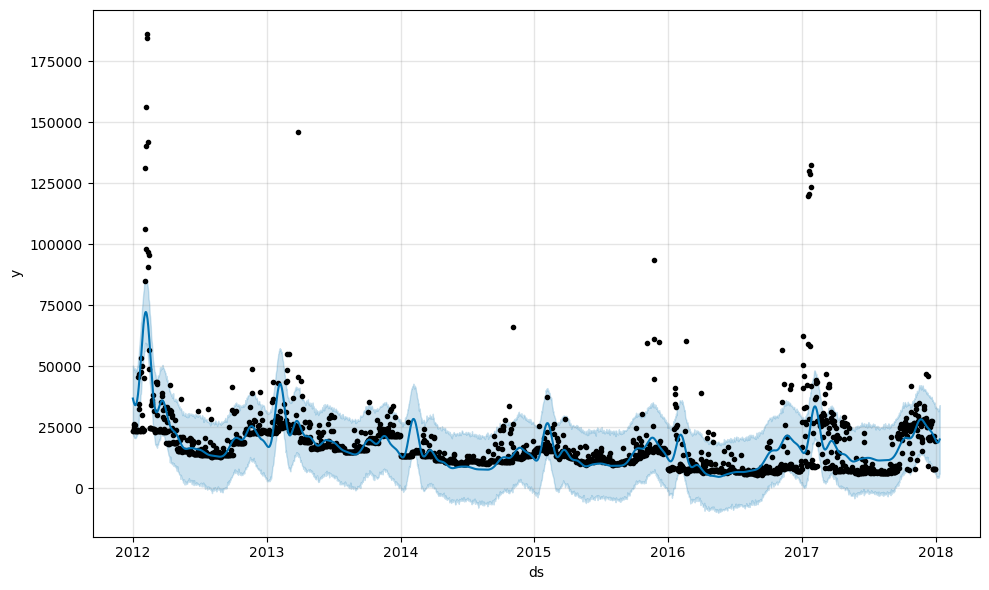

In [28]:
fig = model.plot(forecast)